In [1]:
import networkx as nx
import numpy as np
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
plt.xkcd()
%matplotlib inline

In [2]:
# read data
edge_file = '../data/ENZYMES123.edges'
label_file = '../data/ENZYMES123.node_labels'

f = open(edge_file, 'r')
edge_data = f.readlines()
edge_list = [[int(j) for j in i.strip().split(' ')] for i in edge_data]
f.close()

f = open(label_file, 'r')
label_data = f.readlines()
label_list = [[int(j) for j in i.strip().split(' ')] for i in label_data]
f.close()

In [3]:
# bulid graph
G = nx.from_edgelist(edgelist=edge_list)

# rebulid graph
T = nx.Graph()
T.add_nodes_from(sorted(G.nodes()))
T.add_edges_from(G.edges())

G = T

Analysis

In [4]:
# connected component
component_list = list(nx.connected_components(G))
print('Components count: {}'.format(len(component_list)))
component_sizes = {i:len(comp) for i,comp in enumerate(component_list)}
for k, v in component_sizes.items():
    print('Component {} has size: {}'.format(k, v))

Components count: 1
Component 0 has size: 90


In [5]:
# rebulid graph
G = nx.subgraph(G, component_list[0])

# add labels
label_dict = {k:v for k, v in label_list}
for n,d in G.nodes(data=True):
  d['label'] = label_dict[n]

In [6]:
# analysis plot function
def analysis_plot(G, label_values):
  figsize(20, 6)

  plt.subplot(1, 3, 1)
  nx.draw(G,
      node_color = label_values,
      cmap = plt.get_cmap('Set2'),
      edge_cmap = plt.get_cmap('jet'),
      alpha = 0.8,
      node_size = 100,
      edge_color = [1 if label_values[u-1] != label_values[v-1] else 2 for u,v in G.edges()],
      width = [5 if label_values[u-1] != label_values[v-1] else 1 for u,v in G.edges()])
  
  plt.subplot(1, 3, 2)
  nx.draw(G,
      node_color = label_values,
      cmap = plt.get_cmap('Set2'),
      edge_cmap = plt.get_cmap('jet'),
      alpha = 0.8,
      edge_color = [1 if label_values[u-1] != label_values[v-1] else 2 for u,v in G.edges()],
      pos = nx.shell_layout(G))
  
  plt.subplot(1, 3, 3)
  plt.title('Homogeneity plot')
  plt.xlabel('Mean label value')
  plt.ylabel('Frequency')
  homo_dist = list(map(lambda n: np.mean(label_values[[j-1 for j in list(G.neighbors(n))]]), G.nodes()))
  plt.hist(homo_dist)

  plt.show()

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS', 'StayPuft'] not found. Falling back to DejaVu Sans.
findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS', 'StayPuft'] not found. Falling back to DejaVu Sans.


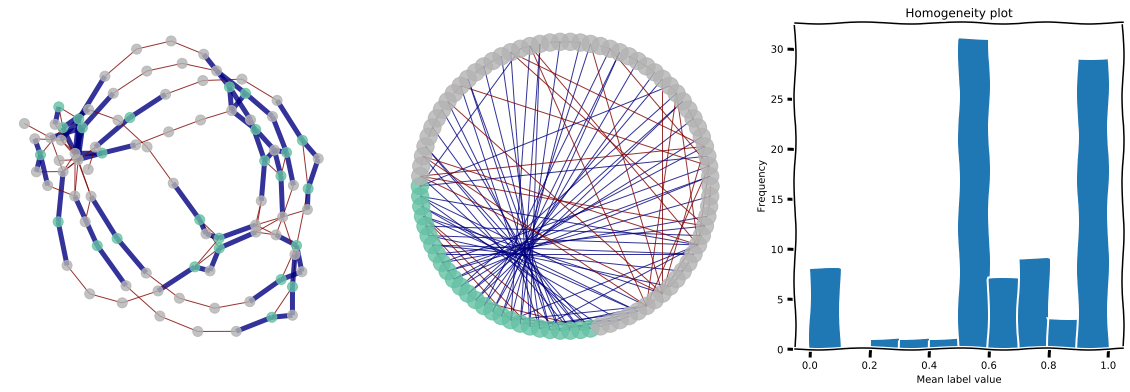

In [7]:
# plot
label_values = np.array(label_list)[:, 1] - 1.0
analysis_plot(G, label_values)

图分析
- 标签不一致的节点出现的蓝色的连接
- 标签一致的节点出现红色的连接
- 左图表明，绿色节点的连接常出现异构
- 中图也能够看出，绿色节点大量连接灰色节点
- 右图中，众数0.5，表明图不同质    


对于此种异构数据进行LPA分类。

In [0]:
# classifier function
def classifier(G, label_values, mask_pos, type='iterative'):
  mask_values = label_values.copy()
  mask_values[mask_pos] = np.nan
  if type == 'iterative':
    init_mask_pos = mask_pos[:]
    iters = 0
    while np.isnan(mask_values).sum() > 0:
      # classification
      pre_labels = np.array(list(map(lambda n: np.round(np.nanmean(mask_values[[int(i-1) for i in list(G.neighbors(n+1))]])), mask_pos)))
      # update labels
      mask_values[mask_pos] = pre_labels
      # update current unknow nodes
      mask_pos = np.where(np.isnan(mask_values))[0]
    acc = (mask_values[init_mask_pos] == label_values[init_mask_pos]).mean()
  elif type == 'relation':
    pre_labels = np.array(list(map(lambda n: np.round(np.nanmean(mask_values[[int(i-1) for i in list(G.neighbors(n+1))]])), mask_pos)))
    acc = (pre_labels == label_values[mask_pos]).mean()
  else:
    raise Exception('Bad Classification Method')
  return acc


# classify
def classify(G, epoch, label_values, mask_size, classifier_type):
  accs = []
  for _ in range(epoch):
    mask_pos = np.random.choice(np.arange(len(label_values)), size=mask_size, replace=False)
    acc = classifier(G, label_values, mask_pos, type=classifier_type)
    accs.append(acc)
  return accs

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


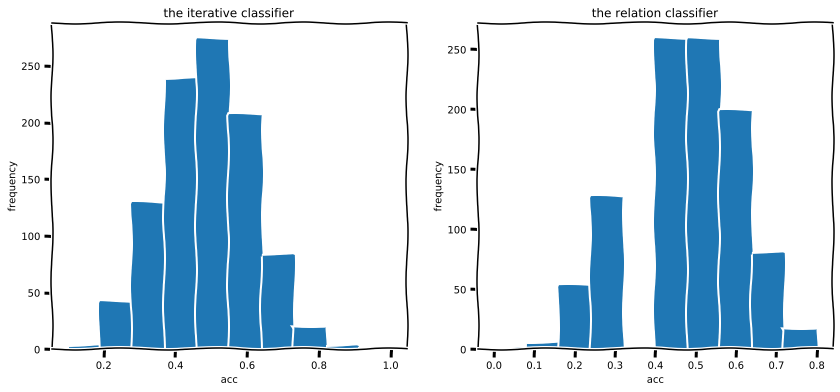

In [10]:
figsize(14, 6)

plt.subplot(1, 2, 1)
plt.title('the iterative classifier')
plt.xlabel('acc')
plt.ylabel('frequency')
plt.hist(classify(G, epoch=1000, label_values=label_values, mask_size=10, classifier_type='iterative'))

plt.subplot(1, 2, 2)
plt.title('the relation classifier')
plt.xlabel('acc')
plt.ylabel('frequency')
plt.hist(classify(G, epoch=1000, label_values=label_values, mask_size=10, classifier_type='relation'))

plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


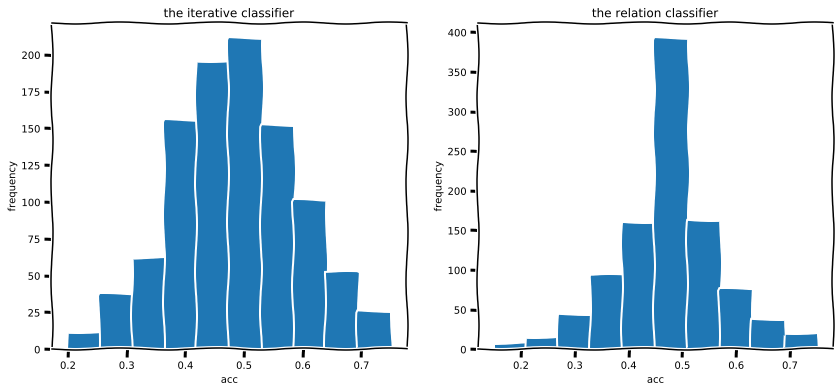

In [11]:
figsize(14, 6)

plt.subplot(1, 2, 1)
plt.title('the iterative classifier')
plt.xlabel('acc')
plt.ylabel('frequency')
plt.hist(classify(G, epoch=1000, label_values=label_values, mask_size=20, classifier_type='iterative'))

plt.subplot(1, 2, 2)
plt.title('the relation classifier')
plt.xlabel('acc')
plt.ylabel('frequency')
plt.hist(classify(G, epoch=1000, label_values=label_values, mask_size=20, classifier_type='relation'))

plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


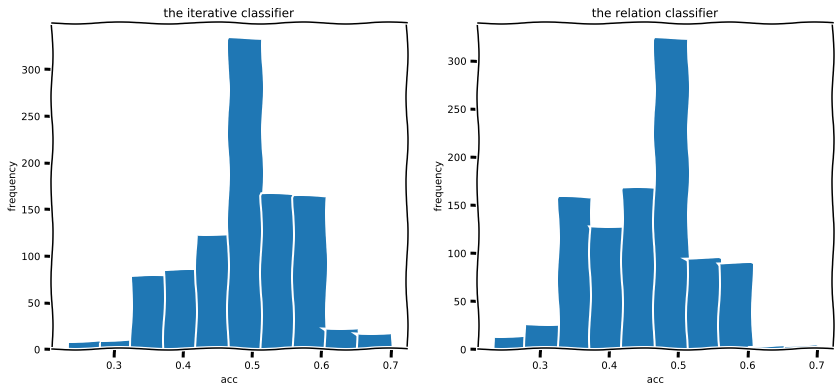

In [12]:
figsize(14, 6)

plt.subplot(1, 2, 1)
plt.title('the iterative classifier')
plt.xlabel('acc')
plt.ylabel('frequency')
plt.hist(classify(G, epoch=1000, label_values=label_values, mask_size=30, classifier_type='iterative'))

plt.subplot(1, 2, 2)
plt.title('the relation classifier')
plt.xlabel('acc')
plt.ylabel('frequency')
plt.hist(classify(G, epoch=1000, label_values=label_values, mask_size=30, classifier_type='relation'))

plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


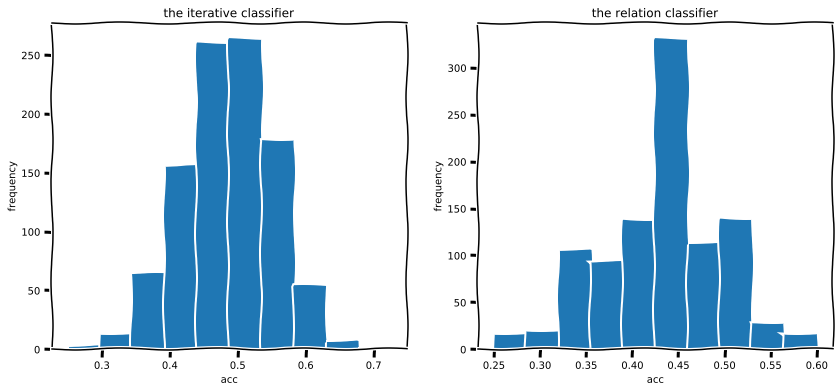

In [13]:
figsize(14, 6)

plt.subplot(1, 2, 1)
plt.title('the iterative classifier')
plt.xlabel('acc')
plt.ylabel('frequency')
plt.hist(classify(G, epoch=1000, label_values=label_values, mask_size=40, classifier_type='iterative'))

plt.subplot(1, 2, 2)
plt.title('the relation classifier')
plt.xlabel('acc')
plt.ylabel('frequency')
plt.hist(classify(G, epoch=1000, label_values=label_values, mask_size=40, classifier_type='relation'))

plt.show()

应用LPA失败。

使用一张新图进行实验。

In [0]:
# new graph
G = nx.karate_club_graph()
label_list = [d['club'] for n,d in G.nodes(data = True)]
club_ids = {club:i for i, club in enumerate(set(label_list))}
label_values = np.array([club_ids[club] for club in label_list],dtype = float)
homo_dist = list(map(lambda n: np.mean(label_values[list(G.neighbors(n))]), G.nodes()))

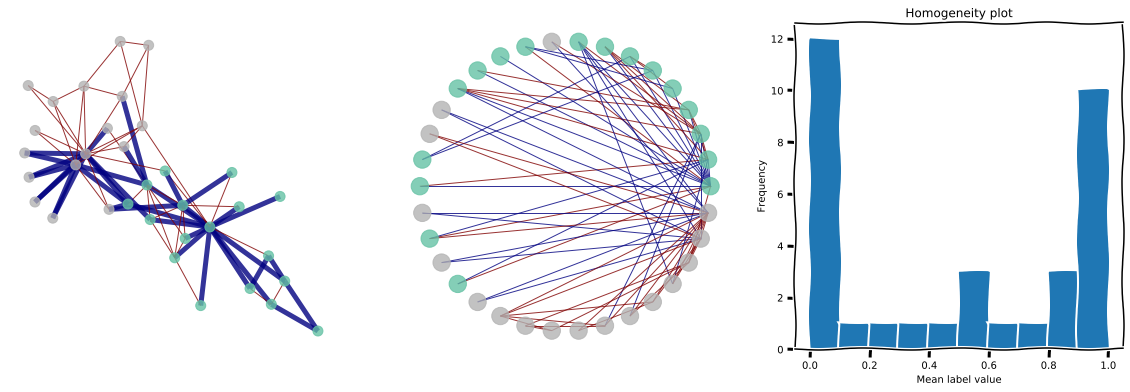

In [24]:
figsize(20,6)

plt.subplot(1,3,1)
nx.draw(G,
    node_color = label_values,
    cmap = plt.get_cmap('Set2'),
    edge_cmap = plt.get_cmap('jet'),
    alpha = 0.8,
    node_size = 100,
    edge_color = [1 if label_values[u-1] != label_values[v-1] else 2 for u,v in G.edges()],
    width = [5 if label_values[u-1]!= label_values[v-1] else 1 for u,v in G.edges()])

plt.subplot(1,3,2)
nx.draw(G,
    node_color = label_values,
    cmap = plt.get_cmap('Set2'),
    edge_cmap = plt.get_cmap('jet'),
    alpha = 0.8,
    edge_color = [1 if label_values[u-1]!= label_values[v-1] else 2 for u,v in G.edges()],
    pos = nx.shell_layout(G))
  
plt.subplot(1,3,3)
plt.title('Homogeneity plot')
plt.xlabel('Mean label value')
plt.ylabel('Frequency')
plt.hist(homo_dist)

plt.show()

In [0]:
# classifier function
def classifier(G, label_values, mask_pos, type='iterative'):
  mask_values = label_values.copy()
  mask_values[mask_pos] = np.nan
  if type == 'iterative':
    init_mask_pos = mask_pos[:]
    iters = 0
    while np.isnan(mask_values).sum() > 0:
      # classification
      pre_labels = np.array(list(map(lambda n: np.round(np.nanmean(mask_values[list(G.neighbors(n))])), mask_pos)))
      # update labels
      mask_values[mask_pos] = pre_labels
      # update current unknow nodes
      mask_pos = np.where(np.isnan(mask_values))[0]
    acc = (mask_values[init_mask_pos] == label_values[init_mask_pos]).mean()
  elif type == 'relation':
    pre_labels = np.array(list(map(lambda n: np.round(np.nanmean(mask_values[list(G.neighbors(n))])), mask_pos)))
    acc = (pre_labels == label_values[mask_pos]).mean()
  else:
    raise Exception('Bad Classification Method')
  return acc


# classify
def classify(G, epoch, label_values, mask_size, classifier_type):
  accs = []
  for _ in range(epoch):
    mask_pos = np.random.choice(np.arange(len(label_values)), size=mask_size, replace=False)
    acc = classifier(G, label_values, mask_pos, type=classifier_type)
    accs.append(acc)
  return accs

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


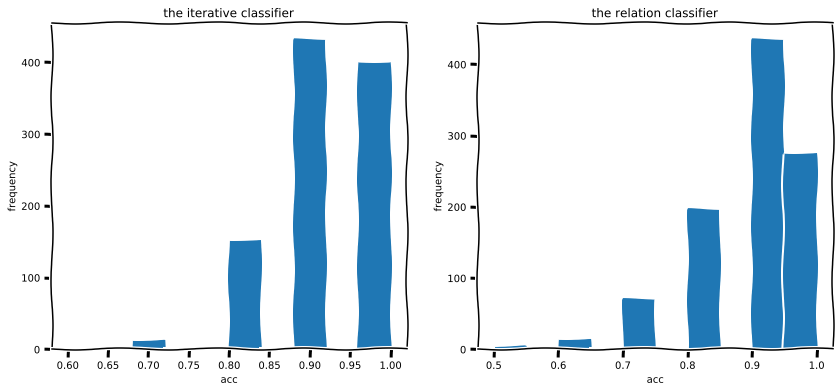

In [36]:
figsize(14, 6)

plt.subplot(1, 2, 1)
plt.title('the iterative classifier')
plt.xlabel('acc')
plt.ylabel('frequency')
plt.hist(classify(G, epoch=1000, label_values=label_values, mask_size=10, classifier_type='iterative'))

plt.subplot(1, 2, 2)
plt.title('the relation classifier')
plt.xlabel('acc')
plt.ylabel('frequency')
plt.hist(classify(G, epoch=1000, label_values=label_values, mask_size=10, classifier_type='relation'))

plt.show()

the acc is good when masking 10 labels.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


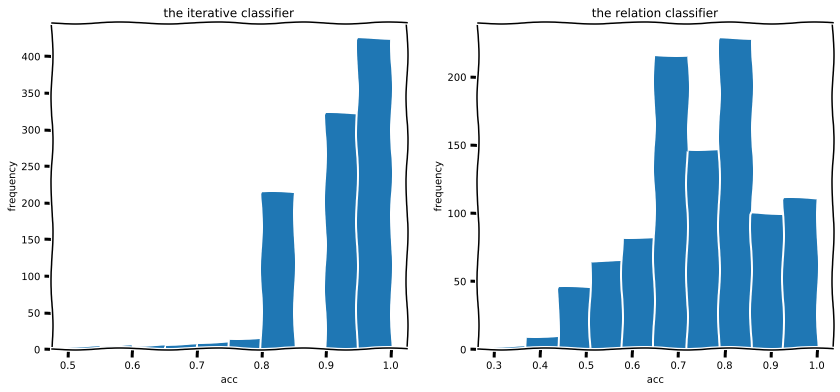

In [34]:
figsize(14, 6)

plt.subplot(1, 2, 1)
plt.title('the iterative classifier')
plt.xlabel('acc')
plt.ylabel('frequency')
plt.hist(classify(G, epoch=1000, label_values=label_values, mask_size=20, classifier_type='iterative'))

plt.subplot(1, 2, 2)
plt.title('the relation classifier')
plt.xlabel('acc')
plt.ylabel('frequency')
plt.hist(classify(G, epoch=1000, label_values=label_values, mask_size=20, classifier_type='relation'))

plt.show()

The acc is good when using the iterative classifier and masking 20 labels.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


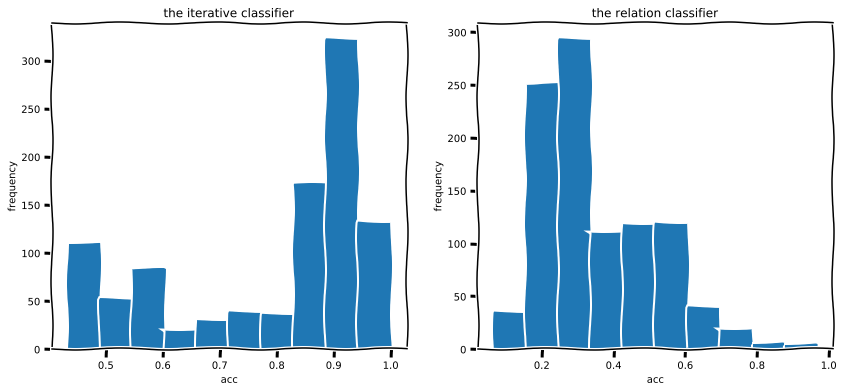

In [35]:
figsize(14, 6)

plt.subplot(1, 2, 1)
plt.title('the iterative classifier')
plt.xlabel('acc')
plt.ylabel('frequency')
plt.hist(classify(G, epoch=1000, label_values=label_values, mask_size=30, classifier_type='iterative'))

plt.subplot(1, 2, 2)
plt.title('the relation classifier')
plt.xlabel('acc')
plt.ylabel('frequency')
plt.hist(classify(G, epoch=1000, label_values=label_values, mask_size=30, classifier_type='relation'))

plt.show()

可视化图

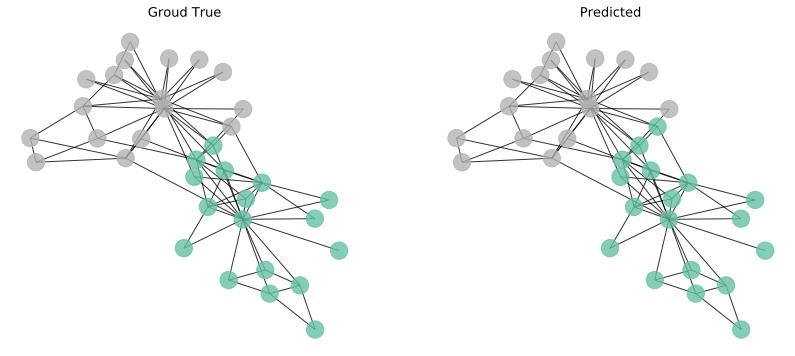

In [43]:
mask_values = label_values.copy()
mask_pos = np.random.choice(np.arange(len(label_values)), size=15, replace=False)
mask_values[mask_pos] = np.nan
init_mask_pos = mask_pos[:]
iters = 0
while np.isnan(mask_values).sum() > 0:
  pre_labels = np.array(list(map(lambda n: np.round(np.nanmean(mask_values[list(G.neighbors(n))])), mask_pos)))
  mask_values[mask_pos] = pre_labels
  mask_pos = np.where(np.isnan(mask_values))[0]

figsize(14,6)
pos = nx.spring_layout(G)
plt.subplot(1,2,1)
nx.draw(G, node_color=label_values, pos=pos, alpha=0.8, cmap=plt.get_cmap('Set2'))
plt.title("Groud True", fontsize=13)
plt.subplot(1,2,2)
nx.draw(G, node_color=mask_values, pos=pos, alpha=0.8, cmap=plt.get_cmap('Set2'))
plt.title("Predicted",fontsize = 13)
plt.show()

大体是一致的。因此，同质的数据可以用LPA进行分类。